In [65]:
import os

os.chdir(str(globals()["_dh"][0]).removesuffix("/statistics"))
print(os.getcwd())

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import yaml
import numpy as np
import shutil

from Statistics import StatSaver, EpisodeStats
from Config import Config
from scipy.signal import savgol_filter

plt.style.use("seaborn-v0_8")

window_length = 200


# Load config file
with open("config.yml", "r") as file:
    global config
    config = Config(yaml.safe_load(file.read()))

loaded_stats: list[EpisodeStats] = StatSaver.load_all_statistics(config.statistics_filename)

# Move to the folder
shutil.rmtree(config.statistics_filename, ignore_errors=True)
os.makedirs(config.statistics_filename, exist_ok=True)
os.chdir(str(os.getcwd() + "/" + config.statistics_filename))
print(os.getcwd())

/home/riccardo/AAS
/home/riccardo/AAS/statistics/QL_AR_MimicFull_Random_B


In [66]:
num_episodes = len(loaded_stats)

episodes_number = []
episodes_winner = []
episodes_winner_hp_remaining = []

episodes_total_reward = []
episodes_total_actions = []

# For each episode
for episode_stat in loaded_stats:
    # Episode Number
    episodes_number.append(episode_stat.episode_number)

    # Episode Winner
    episodes_winner.append(episode_stat.winner_name)

    # Episode Winner HP
    episodes_winner_hp_remaining.append(episode_stat.winner_hp_remaining)

    total_reward = {}  # agentName, total episode reward
    total_actions = {}  # agentName, dict[actionName, count]

    # For each step
    for agentName, action_taken, reward in episode_stat.step_stats:  # step_stat: (agentName, action_taken, reward)
        # Total reward
        if agentName not in total_reward:  # if agent doesn't exist yet
            total_reward[agentName] = 0
        total_reward[agentName] += reward

        # Total count of actions
        if agentName not in total_actions:  # if agent doesn't exist yet
            total_actions[agentName] = {}

        if action_taken not in total_actions[agentName]:  # if action doesn't exist yet
            total_actions[agentName][action_taken] = 0

        total_actions[agentName][action_taken] += 1

    episodes_total_reward.append(total_reward)
    episodes_total_actions.append(total_actions)

In [67]:
all_actions = sorted(
    set().union(*[actions[agentName].keys() for actions in episodes_total_actions for agentName in actions.keys()])
)
episodes_number_np = np.array(episodes_number).reshape(-1, 1)
num_actions = len(all_actions)

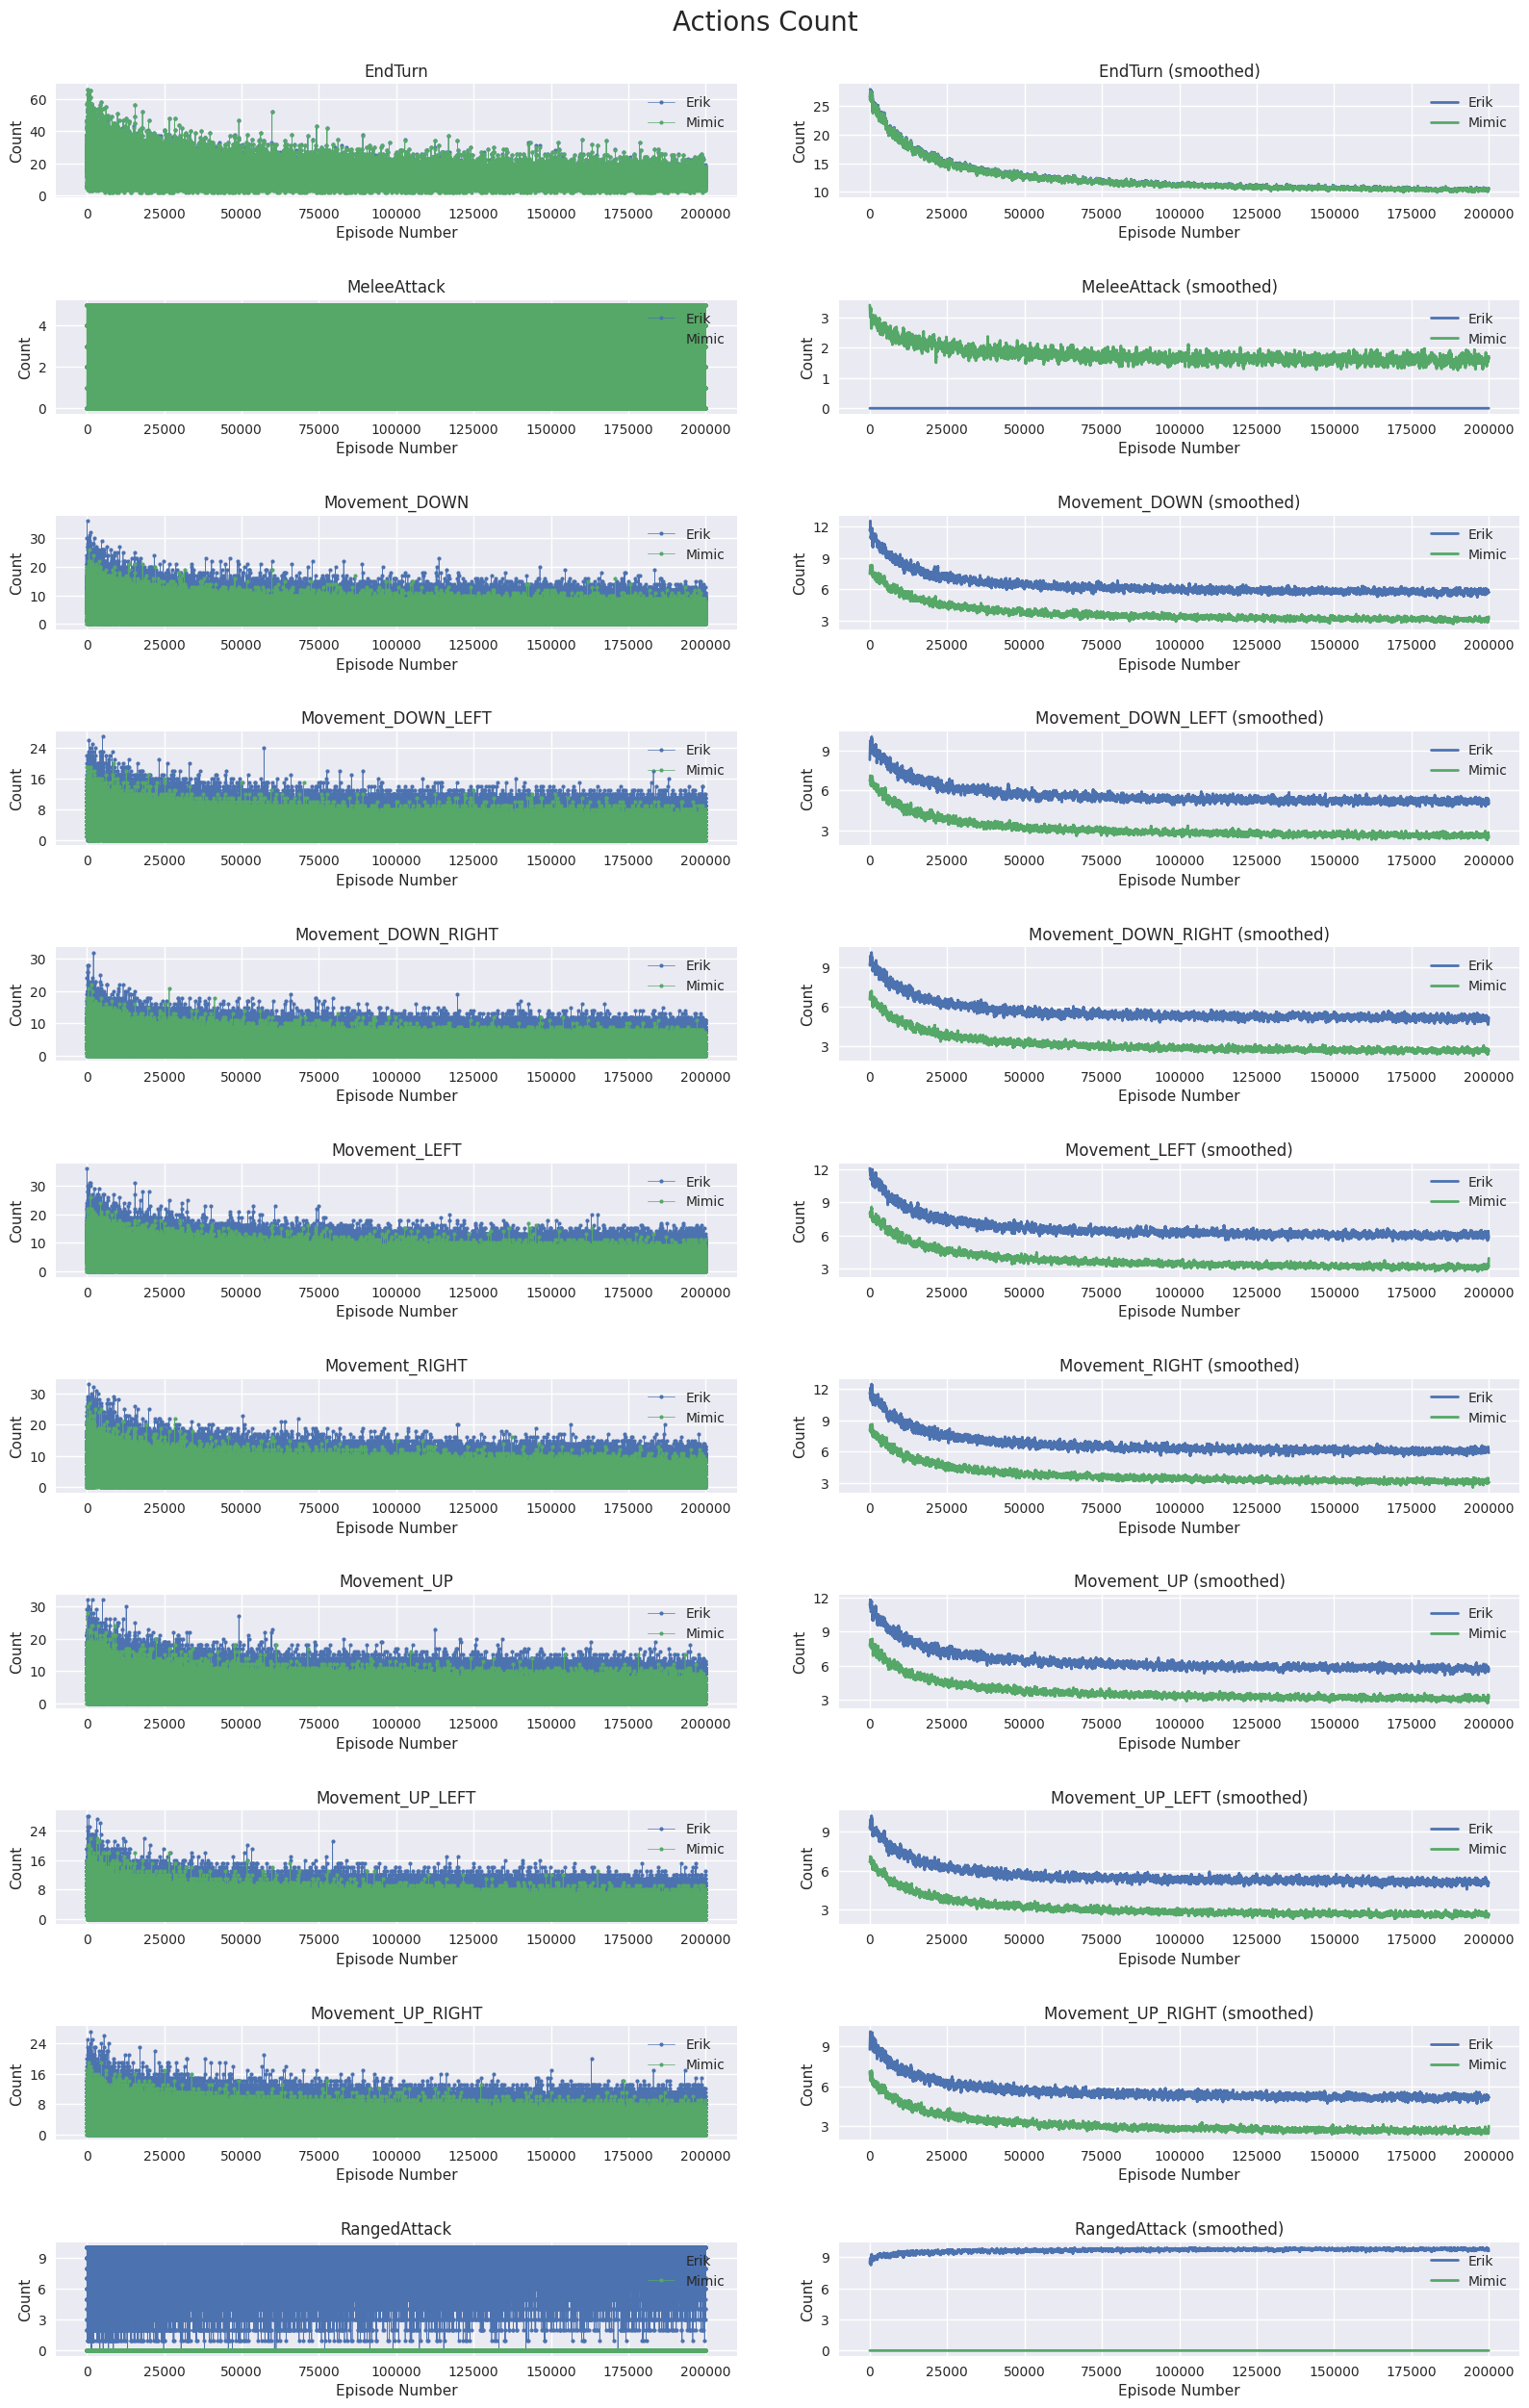

In [68]:
fig, axs = plt.subplots(num_actions, 2, figsize=(16, 25))
axs = axs.ravel()
# For each action
for i, action in enumerate(all_actions):
    # For each agent
    for agentName in episodes_total_actions[0].keys():  # (get agents name from first episode)
        # Entire plot of points
        action_count = [actions[agentName].get(action, 0) for actions in episodes_total_actions]
        axs[2 * i].plot(episodes_number, action_count, "-o", linewidth=0.5, markersize=3, label=agentName)

        # Smoothed data
        smoothed_data = savgol_filter(action_count, window_length, polyorder=1)
        axs[2 * i + 1].plot(episodes_number, smoothed_data, label=f"{agentName}", linewidth=2)

    axs[2 * i].set_title(f"{action}")
    axs[2 * i].set_xlabel("Episode Number")
    axs[2 * i].set_ylabel("Count")
    axs[2 * i].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].legend(loc="upper right")

    axs[2 * i + 1].set_title(f"{action} (smoothed)")
    axs[2 * i + 1].set_xlabel("Episode Number")
    axs[2 * i + 1].set_ylabel("Count")
    axs[2 * i + 1].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].legend(loc="upper right")

fig.suptitle("Actions Count", y=0.999, fontsize=20)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.9)
plt.savefig("1.Actions_Count.png", facecolor="white")
plt.show()

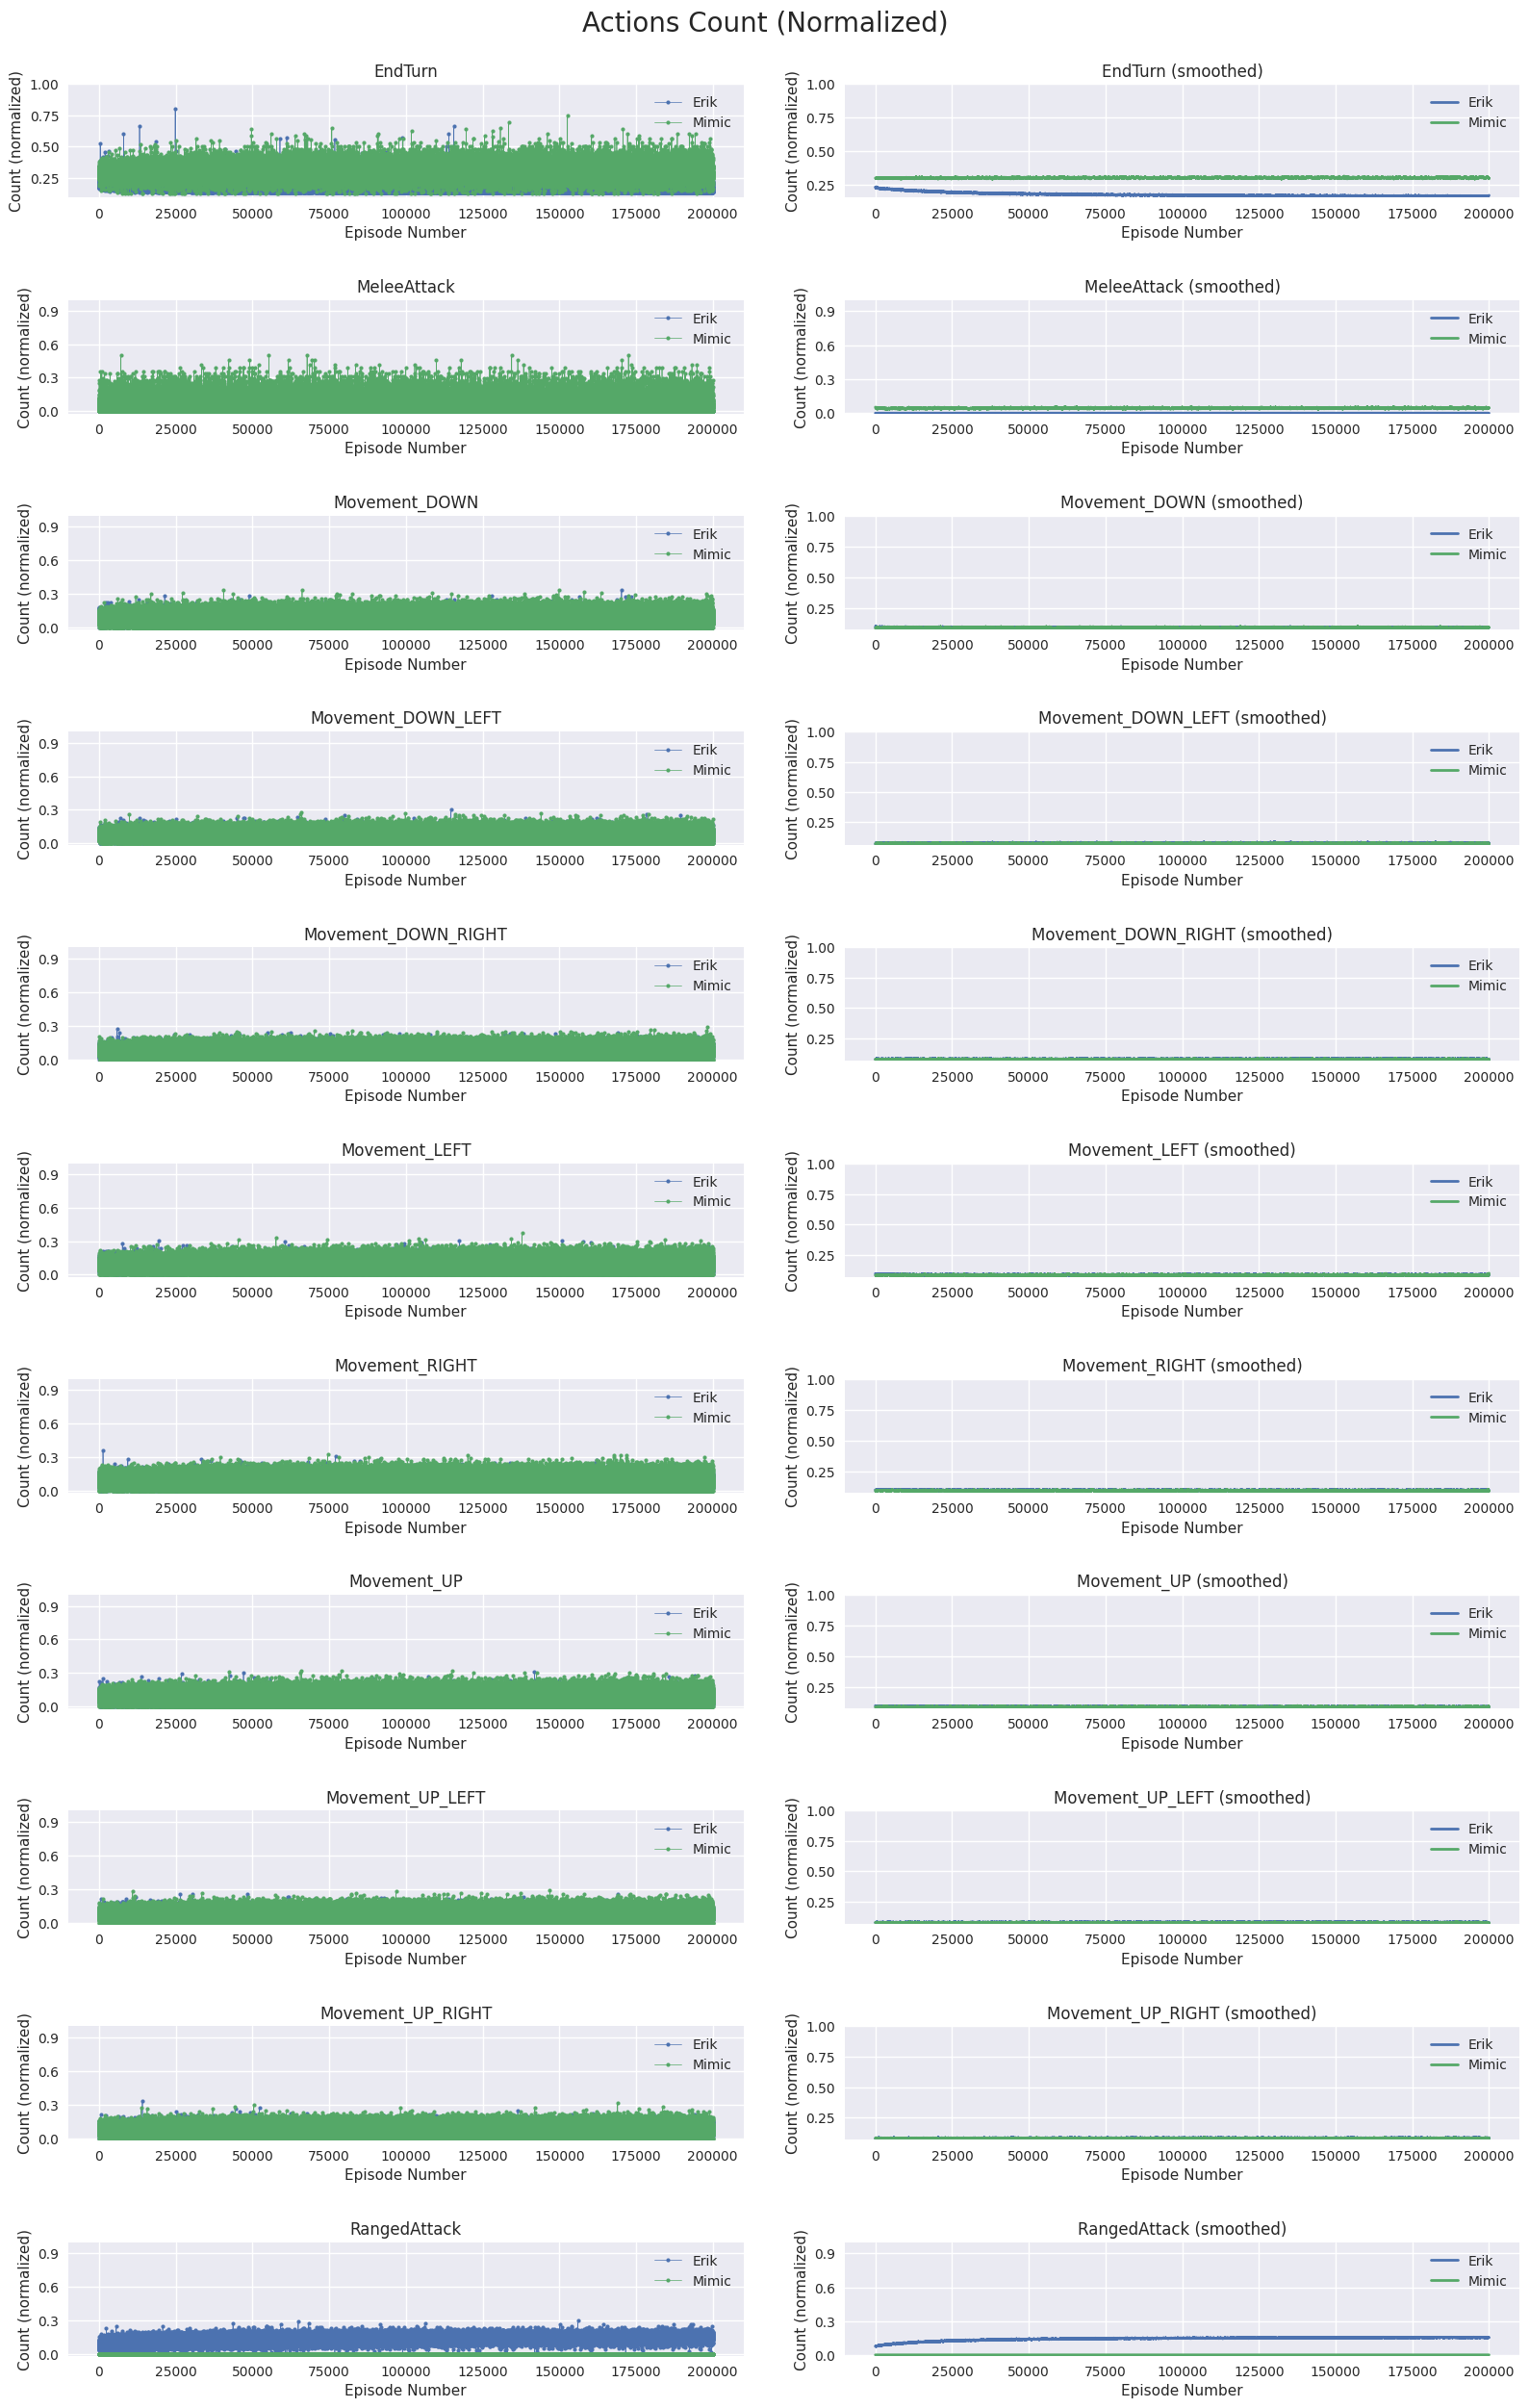

In [69]:
fig, axs = plt.subplots(num_actions, 2, figsize=(16, 25))
axs = axs.ravel()
# For each action
for i, action in enumerate(all_actions):
    # For each agent
    for agentName in episodes_total_actions[0].keys():  # (get agents name from first episode)

        # Get total number of actions taken in each episode by this agent
        total_actions_per_episode = [
            sum(actions[agentName].values()) if agentName in actions else 0 for actions in episodes_total_actions
        ]
        # Number of this action taken in each episode by this agent
        action_count = [
            actions[agentName].get(action, 0) if agentName in actions else 0 for actions in episodes_total_actions
        ]
        # Normalizing
        normalized_action_data = [
            action_count / total_actions if total_actions > 0 else 0
            for action_count, total_actions in zip(action_count, total_actions_per_episode)
        ]

        # Entire plot of points
        axs[2 * i].plot(episodes_number, normalized_action_data, "-o", linewidth=0.5, markersize=3, label=agentName)

        # Smoothed data
        smoothed_data = savgol_filter(normalized_action_data, window_length, polyorder=1)
        axs[2 * i + 1].plot(episodes_number, smoothed_data, label=f"{agentName}", linewidth=2)

    axs[2 * i].set_title(f"{action}")
    axs[2 * i].set_xlabel("Episode Number")
    axs[2 * i].set_ylabel("Count (normalized)")
    axs[2 * i].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i].set_ylim(top=1)
    axs[2 * i].legend(loc="upper right")

    axs[2 * i + 1].set_title(f"{action} (smoothed)")
    axs[2 * i + 1].set_xlabel("Episode Number")
    axs[2 * i + 1].set_ylabel("Count (normalized)")
    axs[2 * i + 1].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
    axs[2 * i + 1].set_ylim(top=1)
    axs[2 * i + 1].legend(loc="upper right")

fig.suptitle("Actions Count (Normalized)", y=0.999, fontsize=20)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.9)
plt.savefig("2.Actions_Count_Normalized.png", facecolor="white")
plt.show()

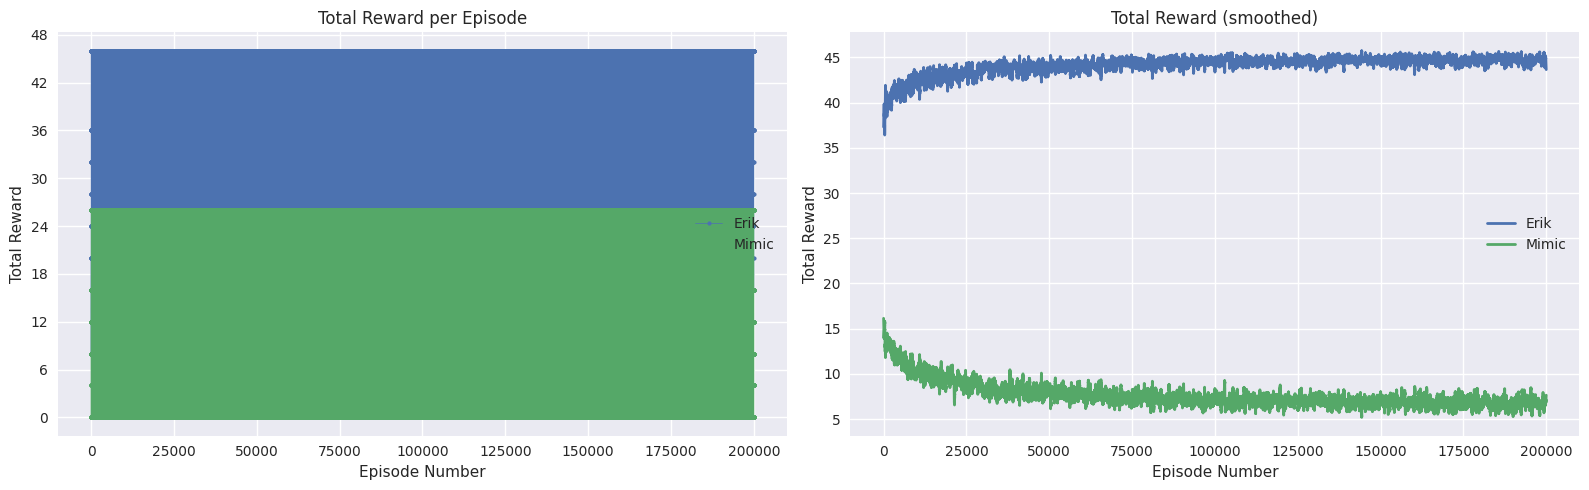

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
for agentName in episodes_total_reward[0].keys():
    total_reward_data = [reward[agentName] for reward in episodes_total_reward]
    axs[0].plot(episodes_number, total_reward_data, "-o", linewidth=0.5, markersize=3, label=agentName)
axs[0].set_title("Total Reward per Episode")
axs[0].set_xlabel("Episode Number")
axs[0].set_ylabel("Total Reward")
axs[0].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[0].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[0].legend()

for agentName in episodes_total_reward[0].keys():
    total_reward_data = [reward[agentName] for reward in episodes_total_reward]

    smoothed_data = savgol_filter(total_reward_data, window_length, polyorder=1)
    axs[1].plot(episodes_number, smoothed_data, label=f"{agentName}", linewidth=2)

axs[1].set_title("Total Reward (smoothed)")
axs[1].set_xlabel("Episode Number")
axs[1].set_ylabel("Total Reward")
axs[1].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[1].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[1].legend()

plt.tight_layout()
plt.savefig("3.Total_Rewards.png", facecolor="white")
plt.show()

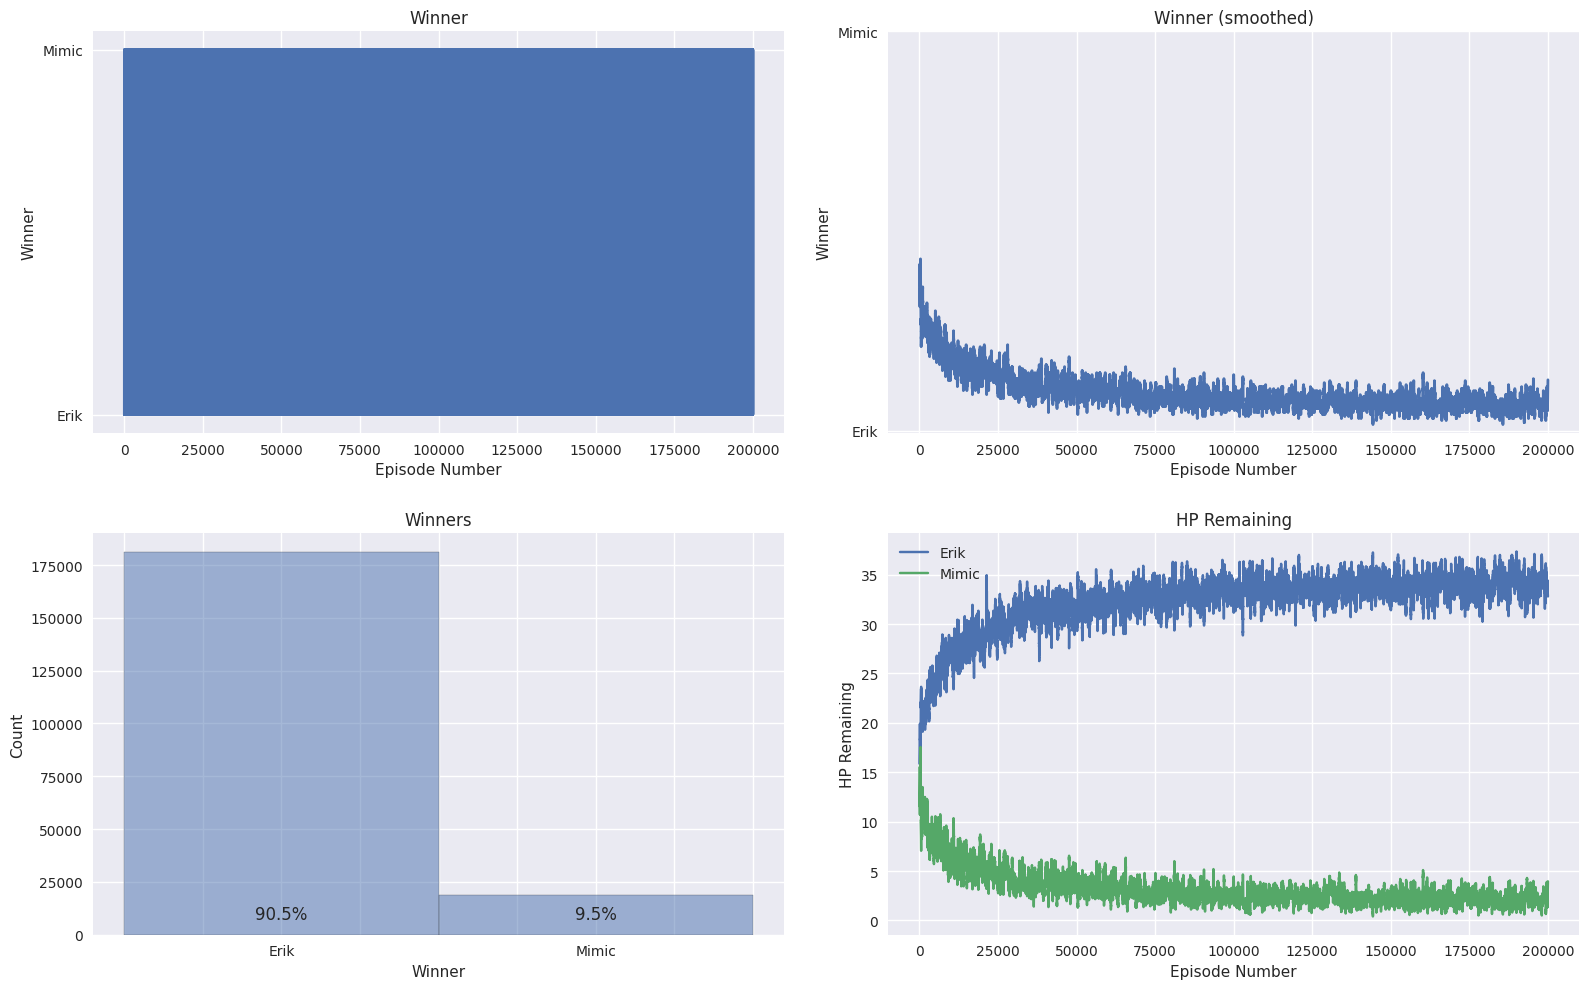

In [71]:
unique_winners = sorted(set(episodes_winner))
winner_numeric = [episodes_winner.index(w) for w in episodes_winner]

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

# Winner over episode
axs[0].plot(episodes_number, winner_numeric, label=f"{agentName}", linewidth=2)
axs[0].set_title("Winner")
axs[0].set_xlabel("Episode Number")
axs[0].set_ylabel("Winner")
axs[0].set_yticks(np.arange(len(unique_winners)))
axs[0].set_yticklabels(unique_winners)
axs[0].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

# Winner over episode smoothed
smoothed_data = savgol_filter(winner_numeric, window_length=window_length, polyorder=1)
axs[1].plot(episodes_number, smoothed_data, label=f"{agentName}", linewidth=2)
axs[1].set_title("Winner (smoothed)")
axs[1].set_xlabel("Episode Number")
axs[1].set_ylabel("Winner")
axs[1].set_yticks(np.arange(len(unique_winners)))
axs[1].set_yticklabels(unique_winners)
axs[1].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

# Histogram of winners
counts, bins, patches = axs[2].hist(
    episodes_winner, bins=np.arange(len(unique_winners) + 1) - 0.5, edgecolor="black", alpha=0.5
)
percentages = (counts / counts.sum()) * 100
height = min([h.get_height() for h in patches])
for patch, percentage in zip(patches, percentages):
    axs[2].text(
        patch.get_x() + patch.get_width() / 2, 0.3 * height, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=12
    )
axs[2].set_title("Winners")
axs[2].set_xlabel("Winner")
axs[2].set_ylabel("Count")
axs[2].set_xticks(np.arange(len(unique_winners)))
axs[2].set_xticklabels(unique_winners)
axs[2].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[2].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

# Hp remaining
hp_remaining_dict = {}
for i, winner in enumerate(episodes_winner):
    if winner not in hp_remaining_dict:
        hp_remaining_dict[winner] = [0] * len(episodes_winner)
    hp_remaining_dict[winner][i] = episodes_winner_hp_remaining[i]
for winner, hp_list in hp_remaining_dict.items():
    smoothed_data = savgol_filter(hp_list, window_length=window_length, polyorder=1)
    axs[3].plot(range(len(episodes_winner)), smoothed_data, label=f"{winner}")
axs[3].set_title("HP Remaining")
axs[3].set_xlabel("Episode Number")
axs[3].set_ylabel("HP Remaining")
axs[3].legend()
axs[3].xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
axs[3].yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.25)
plt.savefig("4.Winners.png", facecolor="white")
plt.show()

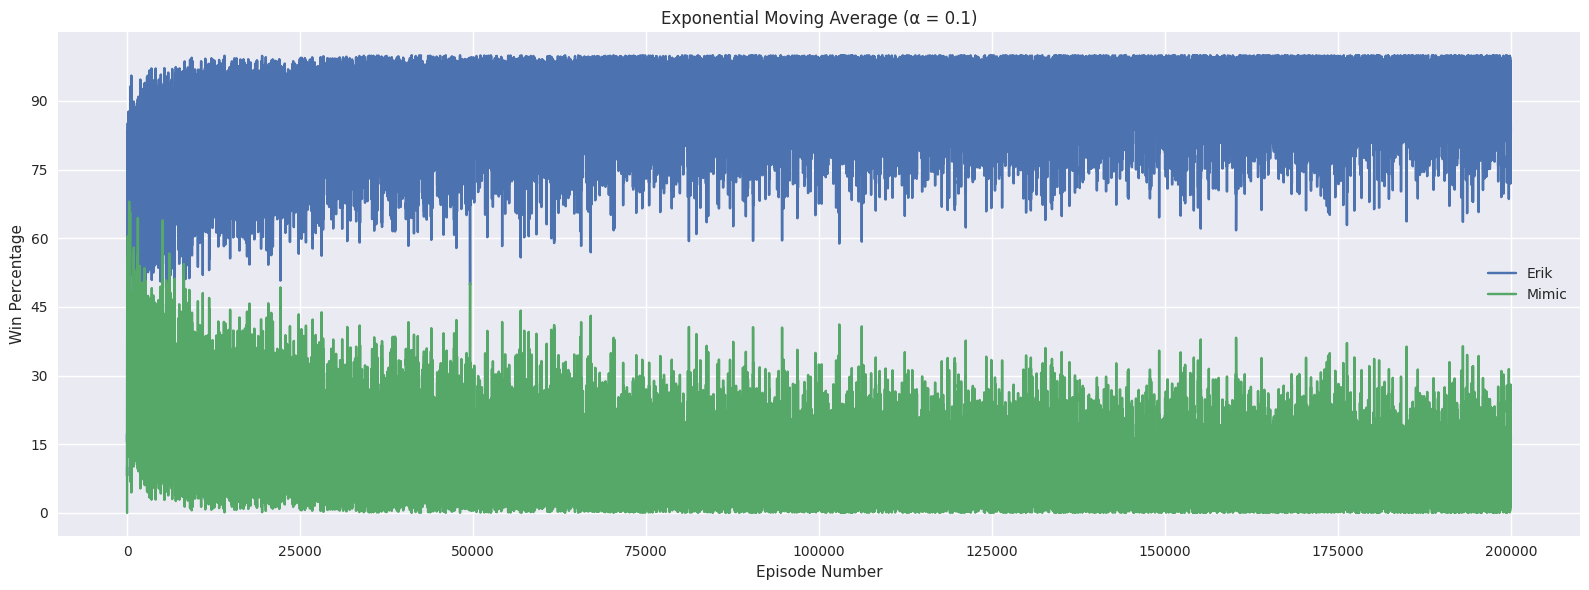

In [72]:
def exponential_moving_average(winners, agent_name, alpha):
    ema = []
    current_ema = 0
    for winner in winners:
        reward = 1 if winner == agent_name else 0
        current_ema = alpha * reward + (1 - alpha) * current_ema
        ema.append(current_ema * 100)  # Convert to percentage
    return ema


alpha = 0.1
plt.figure(figsize=(16, 6))
for winner in unique_winners:
    ema = exponential_moving_average(episodes_winner, winner, alpha)
    plt.plot(episodes_number, ema, label=f"{winner}")
plt.xlabel("Episode Number")
plt.ylabel("Win Percentage")
plt.title(f"Exponential Moving Average (α = {alpha})")
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

plt.tight_layout()
plt.savefig("5.EMA.png", facecolor="white")
plt.show()

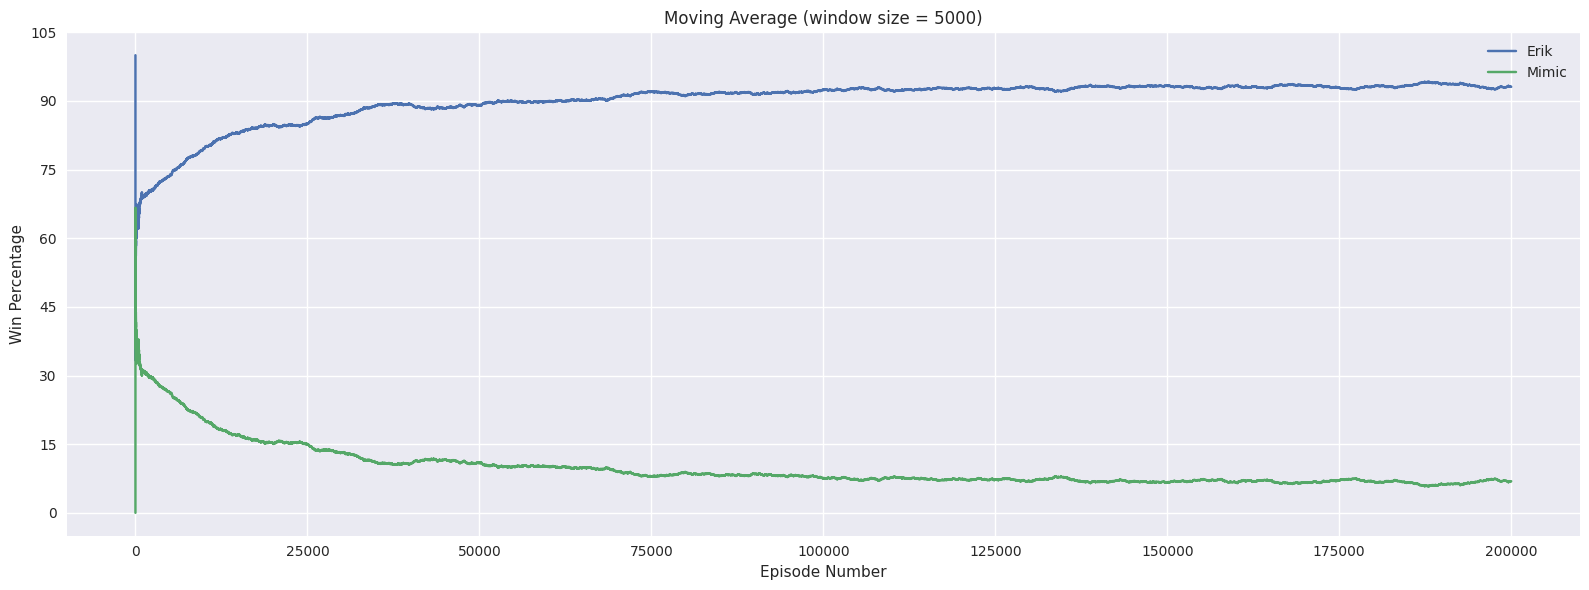

In [73]:
def sliding_window_percentage(winners, agent_name, window_size):
    percentages = []
    for i in range(len(winners)):
        start_index = max(0, i - window_size + 1)
        window = winners[start_index : i + 1]
        total = len(window)
        count = window.count(agent_name)
        percentage = (100 * count) / total
        percentages.append(percentage)
    return percentages


window_size = 5000

plt.figure(figsize=(16, 6))
for winner in unique_winners:
    moving_avg = sliding_window_percentage(episodes_winner, winner, window_size)
    plt.plot(moving_avg, label=f"{winner}")
plt.xlabel("Episode Number")
plt.ylabel("Win Percentage")
plt.title(f"Moving Average (window size = {window_size})")
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins="auto", integer=True, min_n_ticks=3))

plt.tight_layout()
plt.savefig("6.Moving Average.png", facecolor="white")
plt.show()